In [1]:
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.4/163.4 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 12.4 MB/s eta 0:00:00


Intel Image Classifier.

It has test_data.classes classes.
Goal: Building a model that can predict what is in the image.

In [2]:
!mkdir '/root/.kaggle/'

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!pip install kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 10.1 MB/s eta 0:00:00


In [6]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize API
api = KaggleApi()
api.authenticate()  # Ensure your kaggle.json is in ~/.kaggle/

# Download dataset
dataset = "puneet6060/intel-image-classification"
download_path = "final"  # Your target folder

# Download and unzip
api.dataset_download_files(dataset, path=download_path, unzip=True)

print(f"Dataset extracted to: {os.path.abspath(download_path)}")

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
Dataset extracted to: /final


In [9]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 40.8 MB/s eta 0:00:0000:0100:01


In [14]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 28.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 22.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 58.4 MB/s eta 0:00:00


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [8]:
ROOT = 'final'

In [9]:
# classes = os.listdir(images_dir); classes

In [10]:
TRAIN_RATIO = 0.8   #0.8

# data_dir = os.path.join(ROOT, './')
data_dir = os.path.join(ROOT)
train_dir = os.path.join(data_dir, 'seg_train/seg_train')
test_dir = os.path.join(data_dir, 'seg_test/seg_test')

In [11]:
images_dir = os.path.join(data_dir, '/final/seg_test/seg_test')

In [12]:
classes = os.listdir(images_dir)
classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [13]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim= (1, 2))
    stds += torch.std(img, dim= (1, 2))

means /= len(train_data)
stds /= len(train_data)

EDA
Showing its Mean and Standard Dev.

Ploting out the image to inspect the dataset

Split the dataset.

In [14]:
means, stds

(tensor([0.4302, 0.4575, 0.4538]), tensor([0.2355, 0.2345, 0.2429]))

In [15]:
pretrained_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [16]:
test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [17]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)
test_data = datasets.ImageFolder(root = test_dir, 
                                  transform = test_transforms)

In [18]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [19]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [27]:
!nvidia-smi

Fri Jun 27 09:21:31 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64                 Driver Version: 575.64         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX PRO 6000 Blac...    On  |   00000000:01:00.0 Off |                  Off |
| 39%   53C    P8             12W /  600W |       0MiB /  97887MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [28]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 12630
Number of validation examples: 1404
Number of testing examples: 3000


In [29]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [30]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [31]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

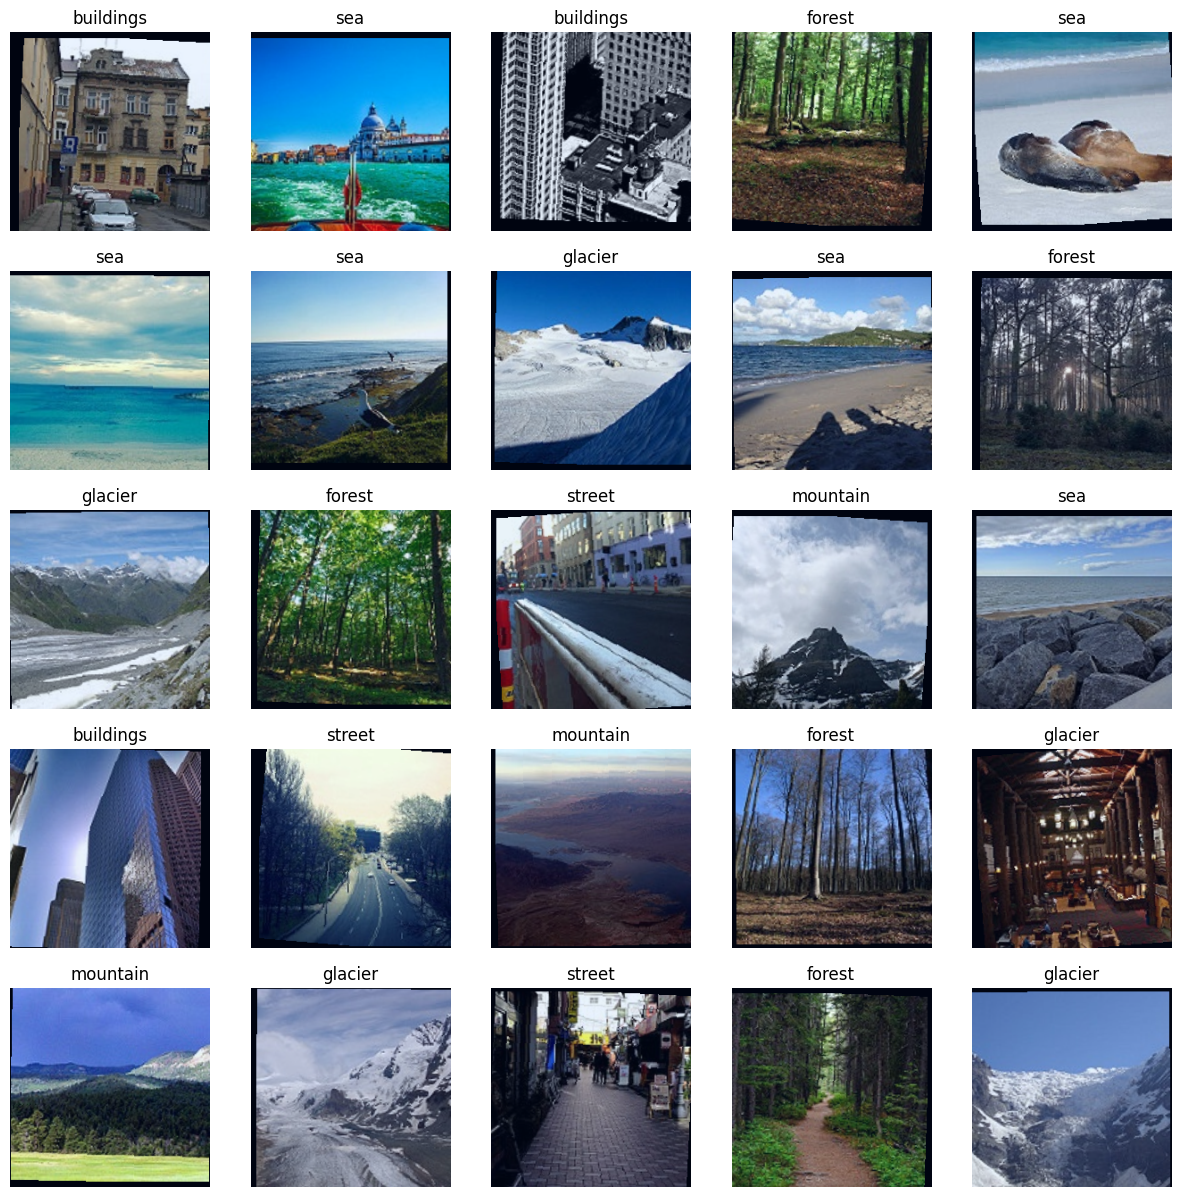

In [32]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

# classes = test_data.classes

plot_images(images, labels, classes)

In [33]:
def format_label(label):
    label = label.split('.')[-1]
    label = label.replace('_', ' ')
    label = label.title()
    label = label.replace(' ', '')
    return label

In [34]:
import torch

# Check if CUDA (NVIDIA GPU) is available
if torch.cuda.is_available():
    # Get the current GPU (assuming single GPU or index 0)
    device = torch.device("cuda:0")
    
    # Query GPU properties
    gpu_props = torch.cuda.get_device_properties(device)
    
    # Print GPU name and total RAM (in GB)
    print(f"GPU Name: {gpu_props.name}")
    print(f"Total GPU RAM: {gpu_props.total_memory / (1024 ** 3):.2f} GB")
else:
    print("No NVIDIA GPU detected!")

GPU Name: NVIDIA RTX PRO 6000 Blackwell Workstation Edition
Total GPU RAM: 94.97 GB


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from functools import partial

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.norm = nn.LayerNorm(dim, eps=1e-6)
    
    def forward(self, x):
        return self.norm(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)

class ConvNeXtBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.norm = LayerNorm(dim)
        self.pwconv1 = nn.Linear(dim, 4 * dim)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
    
    def forward(self, x):
        residual = x
        x = self.dwconv(x)
        x = self.norm(x)
        x = x.permute(0, 2, 3, 1)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = x.permute(0, 3, 1, 2)
        return x + residual

class ConvNeXtTiny(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=4, stride=4),
            LayerNorm(96)
        )
        self.stages = nn.Sequential(
            *[ConvNeXtBlock(96) for _ in range(3)],
            nn.Conv2d(96, 192, kernel_size=2, stride=2),
            *[ConvNeXtBlock(192) for _ in range(3)],
            nn.Conv2d(192, 384, kernel_size=2, stride=2),
            *[ConvNeXtBlock(384) for _ in range(9)],
            nn.Conv2d(384, 768, kernel_size=2, stride=2),
            *[ConvNeXtBlock(768) for _ in range(3)]
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.LayerNorm(768),
            nn.Linear(768, num_classes)
        )
    
    def forward(self, x):
        x = self.stem(x)
        h = self.stages(x)
        return self.head(h), h

# Initialize model
model = ConvNeXtTiny(num_classes=len(test_data.classes))

In [37]:
class LeNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=6,
                               kernel_size=5)

        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=5)

        self.fc_1 = nn.Linear(44944, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, output_dim)

    def forward(self, x):

        # x = [batch size, 3, 28, 28]

        x = self.conv1(x)

        # x = [batch size, 6, 24, 24]

        x = F.max_pool2d(x, kernel_size=2)

        # x = [batch size, 6, 12, 12]

        x = F.relu(x)

        x = self.conv2(x)

        # x = [batch size, 16, 8, 8]

        x = F.max_pool2d(x, kernel_size=2)

        # x = [batch size, 16, 4, 4]

        x = F.relu(x)

        x = x.view(x.shape[0], -1)

        # x = [batch size, 16*4*4 = 256]

        h = x

        x = self.fc_1(x)

        # x = [batch size, 120]

        x = F.relu(x)

        x = self.fc_2(x)

        # x = batch size, 84]

        x = F.relu(x)

        x = self.fc_3(x)

        # x = [batch size, output dim]

        return x, h

modelLe = LeNet(len(test_data.classes))
len(test_data.classes)

6

In [50]:
print()

In [38]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model LeNet has {count_parameters(modelLe):,} trainable parameters')
print(f'The model has {count_parameters(model):,} trainable parameters')

The model LeNet has 5,406,946 trainable parameters
The model has 27,816,774 trainable parameters


In [39]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [40]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):

        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device

        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100,
                   smooth_f = 0.05, diverge_th = 5):

        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)

        iterator = IteratorWrapper(iterator)

        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()

            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]

            if loss < best_loss:
                best_loss = loss

            losses.append(loss)

            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break

        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))

        return lrs, losses

    def _train_batch(self, iterator):

        self.model.train()

        self.optimizer.zero_grad()

        x, y = iterator.get_batch()

        x = x.to(self.device)
        y = y.to(self.device)

        y_pred, _ = self.model(x)

        loss = self.criterion(y_pred, y)

        loss.backward()

        self.optimizer.step()

        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [41]:
import torch
import gc

# Clear PyTorch cache and garbage
torch.cuda.empty_cache()
gc.collect()

# Optional: Reset GPU (nuclear option)
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()

In [42]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [43]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):

    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]

    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

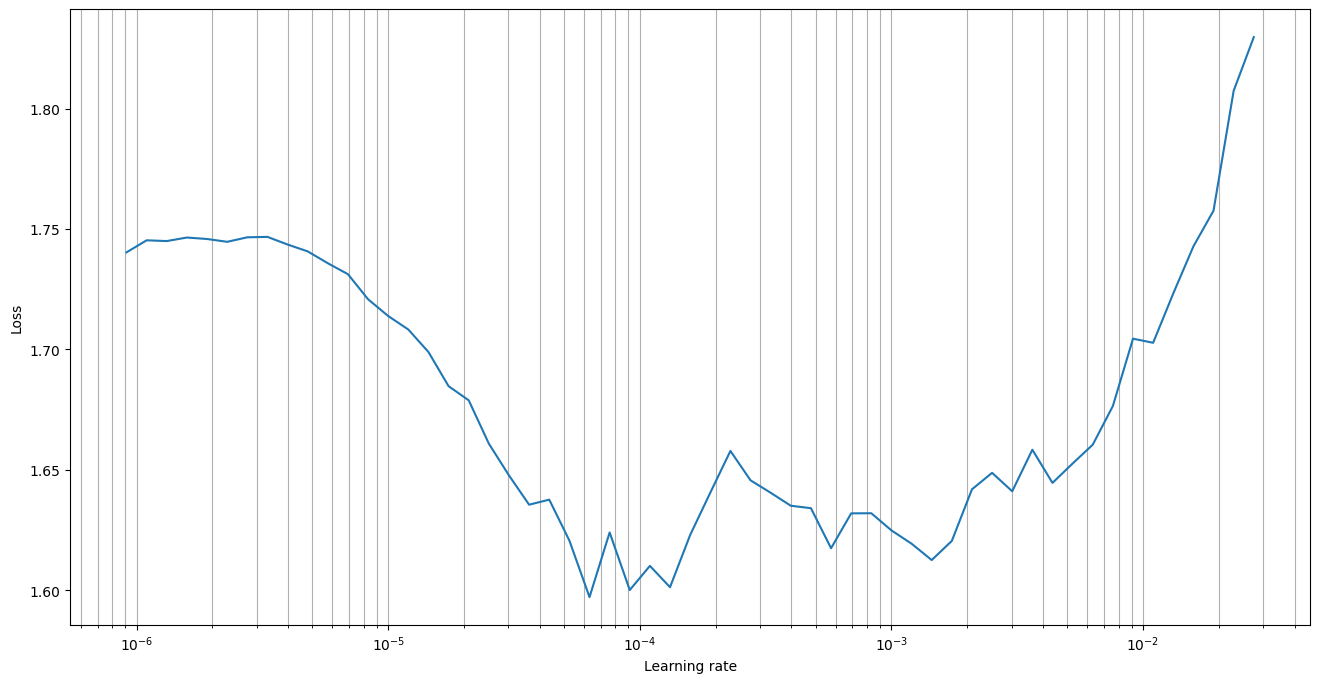

In [44]:
plot_lr_finder(lrs, losses, skip_start = 10, skip_end = 20)

In [45]:
FOUND_LR = 2e-5

params = [
    {'params': model.stem.parameters(), 'lr': FOUND_LR / 10},
    {'params': model.stages[0:4].parameters(), 'lr': FOUND_LR / 8},    # First stage
    {'params': model.stages[4:8].parameters(), 'lr': FOUND_LR / 6},     # Second stage
    {'params': model.stages[8:18].parameters(), 'lr': FOUND_LR / 4},    # Third stage
    {'params': model.stages[18:].parameters(), 'lr': FOUND_LR / 2},     # Fourth stage
    {'params': model.head.parameters()}
]



optimizer = optim.Adam(params, lr = FOUND_LR)

In [46]:
device

device(type='cuda')

In [105]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [106]:
batch_size = train_iterator.batch_size
print(f"Batch size: {batch_size}")

Batch size: 32


In [107]:
def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [108]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [109]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [110]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [111]:
# train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device)
# valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)

In [112]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    model.train()
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    
    # Step the scheduler AFTER optimizer.step()
    scheduler.step()
    
    # Validation phase
    model.eval()
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')
    if(epoch == EPOCHS-2):
        torch.save(model.state_dict(), 'tut5-model.pt')
        break

Epoch: 01 | Epoch Time: 0m 36s
	Train Loss: 0.741 | Train Acc @1:  72.48% | Train Acc @5:  99.60%
	Valid Loss: 0.720 | Valid Acc @1:  73.90% | Valid Acc @5:  99.86%
Epoch: 02 | Epoch Time: 0m 36s
	Train Loss: 0.745 | Train Acc @1:  72.02% | Train Acc @5:  99.62%
	Valid Loss: 0.720 | Valid Acc @1:  73.90% | Valid Acc @5:  99.86%
Epoch: 03 | Epoch Time: 0m 36s
	Train Loss: 0.741 | Train Acc @1:  72.49% | Train Acc @5:  99.60%
	Valid Loss: 0.720 | Valid Acc @1:  73.90% | Valid Acc @5:  99.86%
Epoch: 04 | Epoch Time: 0m 36s
	Train Loss: 0.744 | Train Acc @1:  72.51% | Train Acc @5:  99.62%
	Valid Loss: 0.720 | Valid Acc @1:  73.90% | Valid Acc @5:  99.86%
Epoch: 05 | Epoch Time: 0m 36s
	Train Loss: 0.743 | Train Acc @1:  72.39% | Train Acc @5:  99.51%
	Valid Loss: 0.720 | Valid Acc @1:  73.90% | Valid Acc @5:  99.86%
Epoch: 06 | Epoch Time: 0m 36s
	Train Loss: 0.743 | Train Acc @1:  72.47% | Train Acc @5:  99.56%
	Valid Loss: 0.720 | Valid Acc @1:  73.90% | Valid Acc @5:  99.86%
Epoch: 07 

In [113]:
# We can see the result shows it is not that overfitting as Training acc and valid acc are close.
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

Test Loss: 0.757 | Test Acc @1:  71.80% | Test Acc @5:  99.63%


In [114]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [115]:
images, labels, probs = get_predictions(model, test_iterator)

In [116]:
pred_labels = torch.argmax(probs, 1)

In [119]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(labels, pred_labels, classes):
    plt.figure(figsize=(20, 20))  # Reduced figure size
    ax = plt.gca()
    
    # Create a confusion matrix
    cm = confusion_matrix(labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    # Plot with larger text
    disp.plot(ax=ax, values_format='d', cmap='Blues',
              colorbar=False,  # Remove colorbar
              xticks_rotation=90)  # Rotate x-axis labels
    
    # Adjust font sizes
    ax.tick_params(axis='both', which='major', labelsize=20)  # Tick label size
    ax.set_xlabel('Predicted Label', fontsize=24)  # X-axis label
    ax.set_ylabel('True Label', fontsize=24)  # Y-axis label
    ax.set_title('Confusion Matrix', fontsize=28)  # Title
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

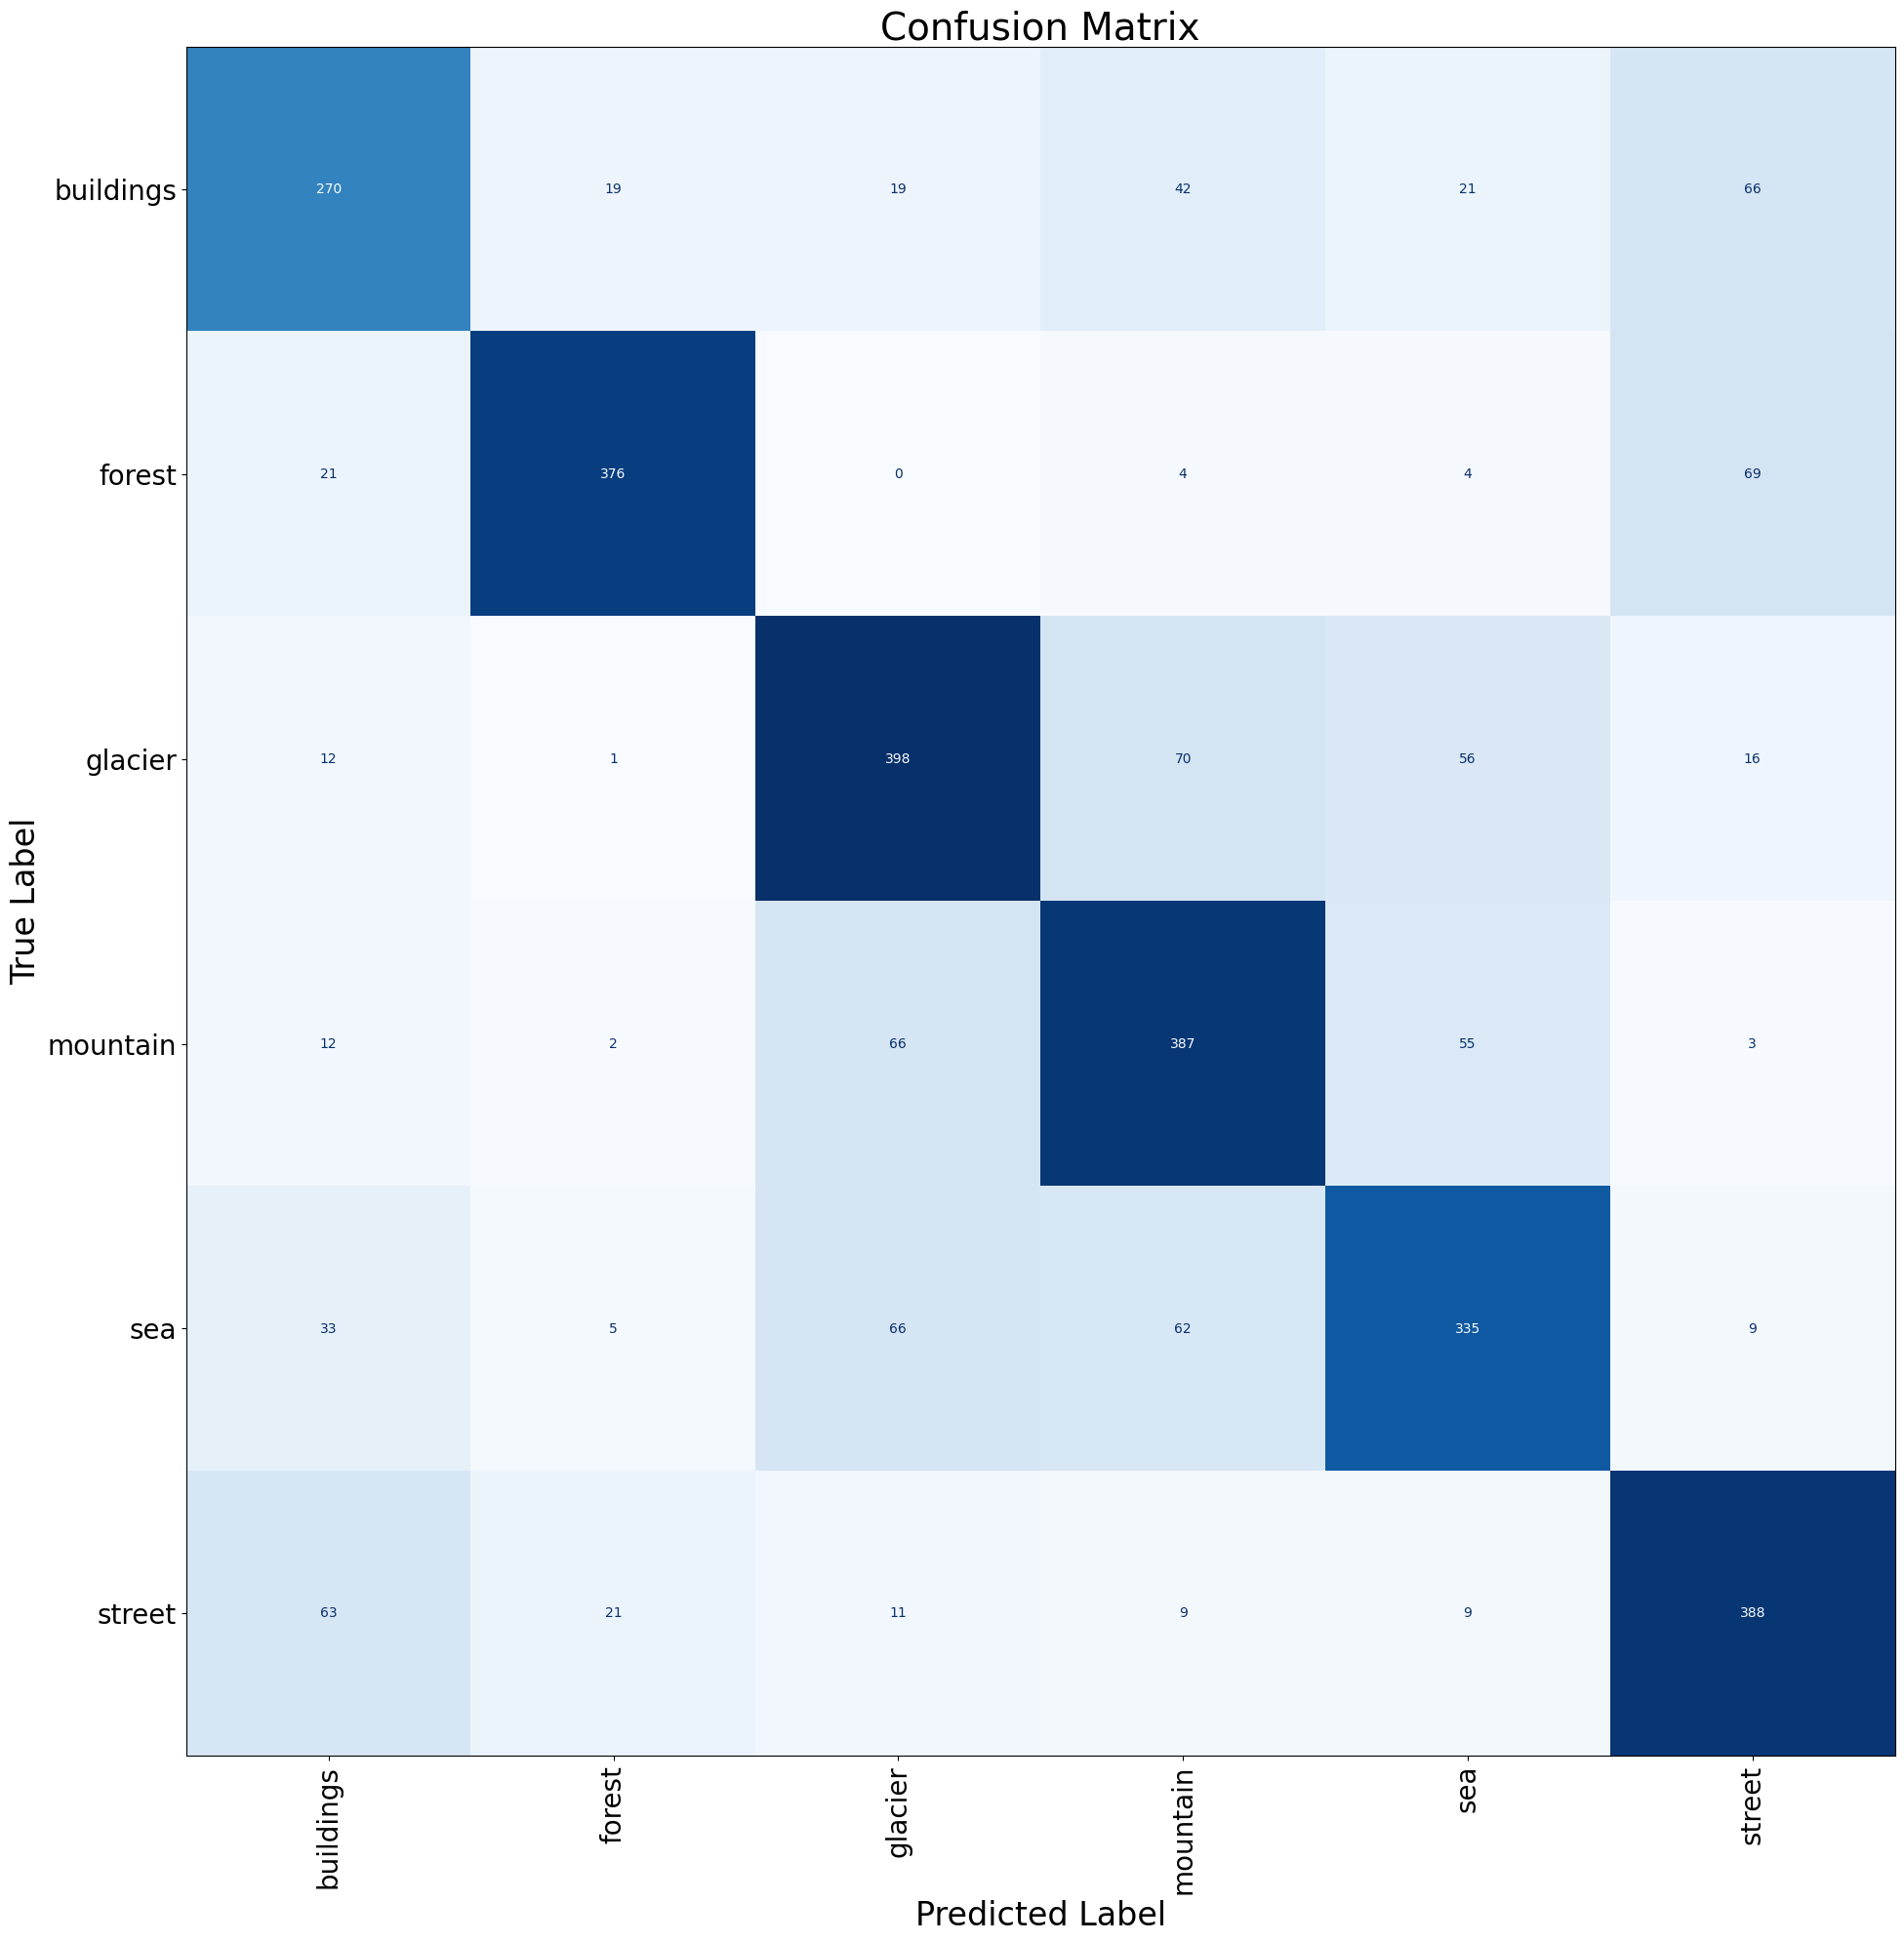

In [120]:
plot_confusion_matrix(labels, pred_labels, classes)

In [126]:
# Another Model:
FOUND_LR = 1e-3

params = [
    {'params': model.stem.parameters(), 'lr': FOUND_LR / 10},
    {'params': model.stages[0:4].parameters(), 'lr': FOUND_LR / 8},    # First stage
    {'params': model.stages[4:8].parameters(), 'lr': FOUND_LR / 6},     # Second stage
    {'params': model.stages[8:18].parameters(), 'lr': FOUND_LR / 4},    # Third stage
    {'params': model.stages[18:].parameters(), 'lr': FOUND_LR / 2},     # Fourth stage
    {'params': model.head.parameters()}
]


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

modelLe = modelLe.to(device)
criterion = criterion.to(device)
optimizerl = optim.Adam(params, lr = FOUND_LR)
modelLe

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=44944, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=6, bias=True)
)

In [127]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    modelLe.train()
    train_loss, train_acc_1, train_acc_5 = train(modelLe, train_iterator, optimizer, criterion, scheduler, device)
    
    # Step the scheduler AFTER optimizer.step()
    scheduler.step()
    
    # Validation phase
    modelLe.eval()
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(modelLe, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(modelLe.state_dict(), 'tut5-modelLe.pt')
    
    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')
    if(epoch == EPOCHS-2):
        torch.save(modelLe.state_dict(), 'tut5-modelLe.pt')
        break

Epoch: 01 | Epoch Time: 0m 9s
	Train Loss: 1.792 | Train Acc @1:  17.21% | Train Acc @5:  86.08%
	Valid Loss: 1.791 | Valid Acc @1:  18.47% | Valid Acc @5:  87.25%
Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 1.792 | Train Acc @1:  17.15% | Train Acc @5:  86.36%
	Valid Loss: 1.791 | Valid Acc @1:  18.47% | Valid Acc @5:  87.25%
Epoch: 03 | Epoch Time: 0m 9s
	Train Loss: 1.792 | Train Acc @1:  17.31% | Train Acc @5:  86.65%
	Valid Loss: 1.791 | Valid Acc @1:  18.47% | Valid Acc @5:  87.25%
Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 1.792 | Train Acc @1:  16.91% | Train Acc @5:  86.81%
	Valid Loss: 1.791 | Valid Acc @1:  18.47% | Valid Acc @5:  87.25%
Epoch: 05 | Epoch Time: 0m 9s
	Train Loss: 1.792 | Train Acc @1:  17.39% | Train Acc @5:  86.39%
	Valid Loss: 1.791 | Valid Acc @1:  18.47% | Valid Acc @5:  87.25%
Epoch: 06 | Epoch Time: 0m 9s
	Train Loss: 1.792 | Train Acc @1:  17.04% | Train Acc @5:  86.37%
	Valid Loss: 1.791 | Valid Acc @1:  18.47% | Valid Acc @5:  87.25%
Epoch: 07 | Epoc

In [132]:
## We can see the result shows it is not that overfitting as Training acc and valid acc are close.
images, labels, probs = get_predictions(modelLe, test_iterator)
pred_labels = torch.argmax(probs, 1)

In [133]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(labels, pred_labels, classes):
    plt.figure(figsize=(20, 20))  # Reduced figure size
    ax = plt.gca()
    
    # Create a confusion matrix
    cm = confusion_matrix(labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    # Plot with larger text
    disp.plot(ax=ax, values_format='d', cmap='Blues',
              colorbar=False,  # Remove colorbar
              xticks_rotation=90)  # Rotate x-axis labels
    
    # Adjust font sizes
    ax.tick_params(axis='both', which='major', labelsize=20)  # Tick label size
    ax.set_xlabel('Predicted Label', fontsize=24)  # X-axis label
    ax.set_ylabel('True Label', fontsize=24)  # Y-axis label
    ax.set_title('Confusion Matrix', fontsize=28)  # Title
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

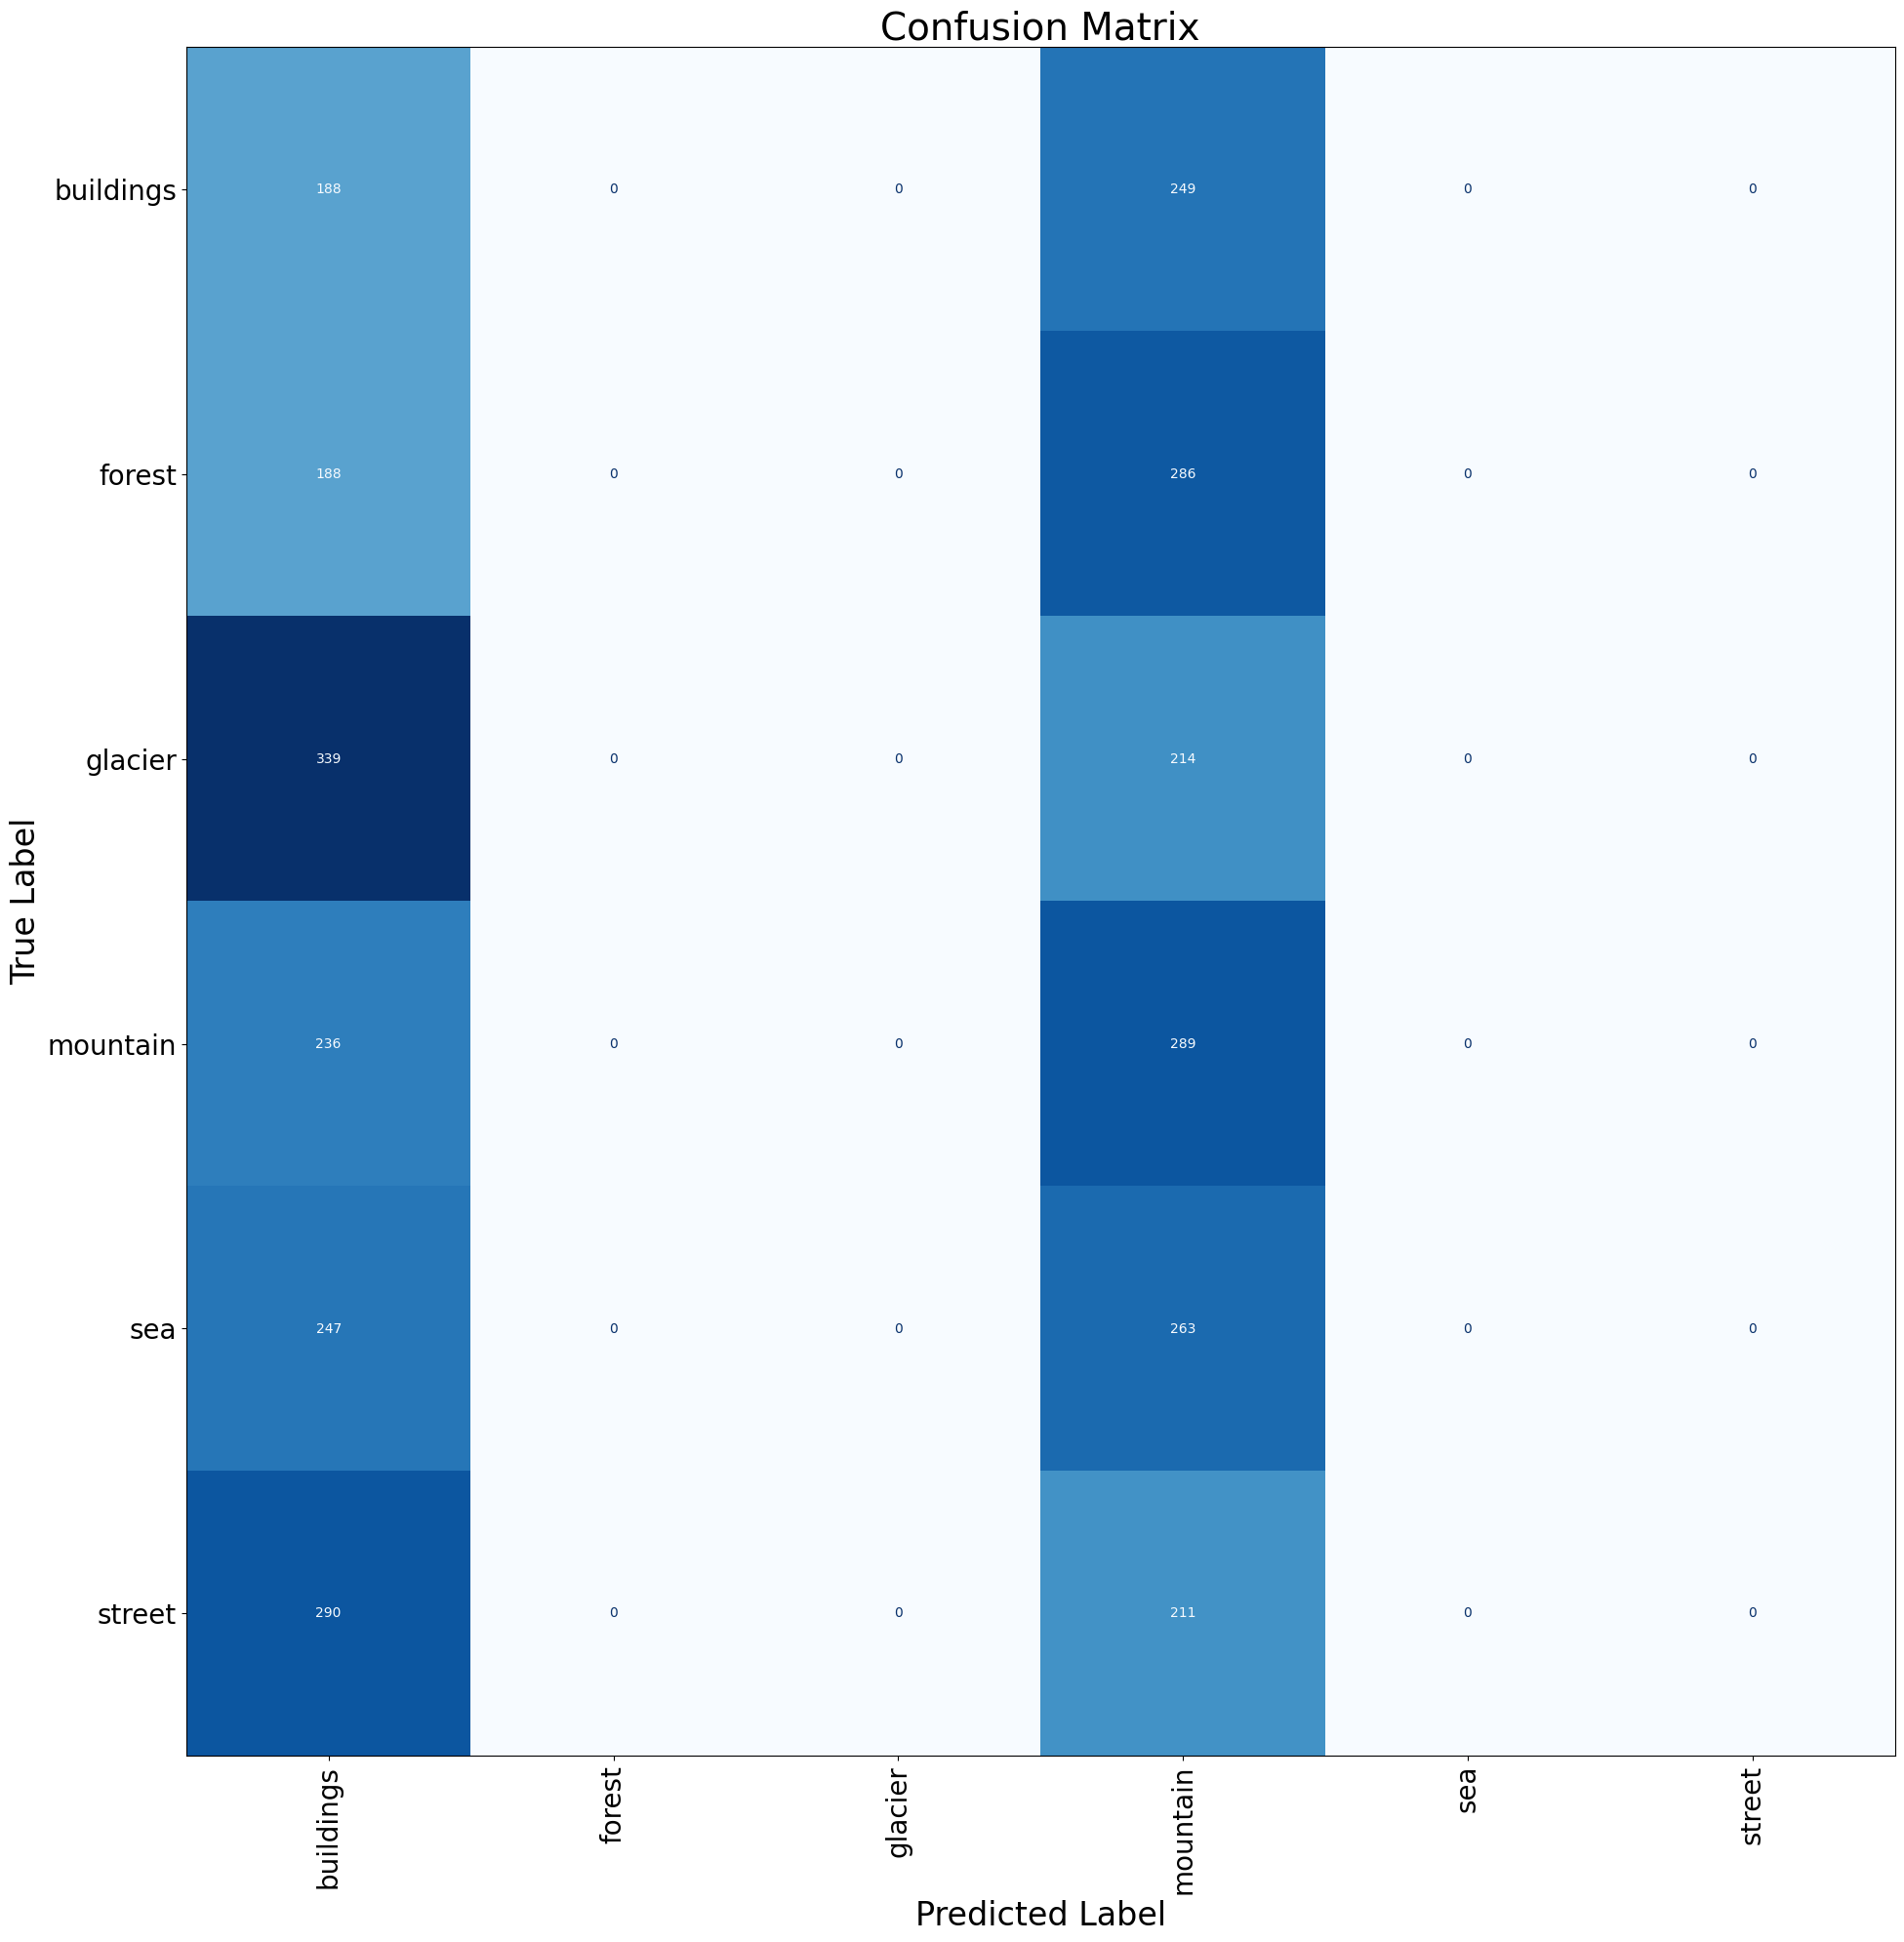

In [134]:
plot_confusion_matrix(labels, pred_labels, classes)

In the end, ConvNext is better than the old LucNet. Bigger model and newer model is better than the old one.

In [131]:
test_data.classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']